In [ ]:
import cv2
import numpy as np
import os
from glob import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models

In [ ]:
# Inverted preprocess
def preprocess(input_image):
    blurred = cv2.GaussianBlur(input_image, (5, 5), 0)
    inverted = 255 - blurred  # Invert to make cells bright
    equalized = cv2.equalizeHist(inverted)
    equalized = cv2.equalizeHist(blurred)

    return equalized

# Analyze and annotate function
def analyze_and_annotate(img):
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    annotated_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(annotated_img, contours, -1, (0, 255, 0), 2)
    return thresh  # Return thresholded mask

# Masking function
def mask_image(thresh, output_path, dataset_type='train'):
    # Define mask directory based on dataset type
    mask_dir = f'{dataset_type}/masks' if dataset_type in ['train', 'test'] else 'masks'
    os.makedirs(mask_dir, exist_ok=True)
    mask_path = os.path.join(mask_dir, os.path.basename(output_path).replace('.png', '_mask.png'))
    cv2.imwrite(mask_path, thresh)
    return mask_path

# Function to extract sequence and timestamp
def extract_seq_time(path):
    filename = os.path.basename(path)
    seq_match = re.search(r'Phase_([A-D]\d+_\d+)', filename)
    seq = seq_match.group(1) if seq_match else 'Unknown'
    time_match = re.search(r'(\d+)d(\d+)h(\d+)m', filename)
    if time_match:
        d, h, m = map(int, time_match.groups())
        time_min = d * 1440 + h * 60 + m
    else:
        time_min = 0
    return seq, time_min, path

In [ ]:
# # Display the sorted DataFrame
# print("\nSorted DataFrame Summary:")
# display(df.head())
# print(f"\nTotal entries: {len(df)}")

# showing sorted images for verifying whether the images are sequential in order

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def show_mapping(dataset_type='test', start=0,number_of_images=0,iterate=1):
    # Define directories based on dataset type in /kaggle/working/
    if dataset_type == 'train':
        data_dir = '/kaggle/input/analysed-data/train/original'  # Original images
        processed_dir = '/kaggle/input/analysed-data/train/processed'
        mask_dir = '/kaggle/input/analysed-data/train/masks'  # Mask images
    elif dataset_type == 'test':
        data_dir = '/kaggle/input/analysed-data/test/original'  # Assuming val data exists
        processed_dir = '/kaggle/input/analysed-data/test/processed'
        mask_dir = '/kaggle/input/analysed-data/test/masks'
    else:
        raise ValueError("dataset_type must be 'train' or 'test'")

    # Get paths from original images
    paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.png')]

    # Check if paths exist
    if not paths:
        print(f"No {dataset_type} images found in {data_dir}.")
        return

    # Sort paths to ensure consistent order (e.g., alphabetical)
    paths.sort()

    # Select first N images
    paths = [paths[i] for i in range(start,number_of_images,iterate)]

    for path in paths:
        # Load original image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error loading original image: {path}")
            continue

        # Load preprocessed image
        filename = os.path.basename(path)
        preprocessed_path = os.path.join(processed_dir, filename)
        preprocessed = cv2.imread(preprocessed_path, cv2.IMREAD_GRAYSCALE)
        if preprocessed is None:
            print(f"Error loading preprocessed image: {preprocessed_path}")
            continue

        # Load mask image
        mask_path = os.path.join(mask_dir, filename.replace('.png', '_mask.png'))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error loading mask image: {mask_path}")
            continue

        # Create and display plot
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img, cmap='gray')
        axs[0].set_title(f'Raw  Image')
        axs[0].axis('off')
        axs[1].imshow(preprocessed, cmap='gray')
        axs[1].set_title(f'Preprocessed  ')
        axs[1].axis('off')
        axs[2].imshow(mask, cmap='gray')
        axs[2].set_title(f' Masked')
        axs[2].axis('off')
        plt.show()



In [ ]:
show_mapping(dataset_type='train',start=0,number_of_images=70,iterate=4)

In [ ]:
# show_mapping('test',start=4 ,number_of_images=10)


modify and analyse masked data

In [ ]:
import os
import numpy as np
from glob import glob
import tensorflow as tf

   
# Path to your mask sequences
mask_base_path = '/kaggle/input/analysed-data/combined_masks'
classes = ['B10_1', 'B10_2', 'C10_1', 'C10_2', 'D10_1', 'D10_2']

print("=== LOADING YOUR MASK DATA ===")

# Load all mask sequences
all_sequences = []
all_targets = []

for class_name in classes:
    class_path = os.path.join(mask_base_path, class_name)
    mask_files = sorted(glob(os.path.join(class_path, '*.png')))
    
    print(f"{class_name}: {len(mask_files)} masks")
    
    # Create sequences: 4 masks → predict 5th mask
    for i in range(len(mask_files) - 5):
        # Input sequence (4 consecutive masks)
        sequence = []
        for j in range(4):
            # Load and resize to 128x128
            img = tf.keras.preprocessing.image.load_img(mask_files[i+j], color_mode='grayscale')
            img = img.resize((128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            sequence.append(img_array)
        
        # Target (5th mask)
        target_img = tf.keras.preprocessing.image.load_img(mask_files[i+4], color_mode='grayscale')
        target_img = target_img.resize((128, 128))
        target_array = tf.keras.preprocessing.image.img_to_array(target_img)
        
        all_sequences.append(np.array(sequence))
        all_targets.append(target_array)

# Convert to numpy arrays
X = np.array(all_sequences).astype('float32') / 255.0
y = np.array(all_targets).astype('float32') / 255.0

print(f"X shape before reshape: {X.shape}")
print(f"y shape before reshape: {y.shape}")

# Reshape to correct dimensions
X = X.reshape(-1, 4, 128, 128, 1)  # (samples, timesteps, height, width, channels)
y = y.reshape(-1, 128, 128, 1)     # (samples, height, width, channels)

print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")

# MOVE D10 TO TARGETS ONLY
print("\n=== SEPARATING D10 FOR TESTING ===")

# Calculate samples per class
total_samples = len(X)
samples_per_class = total_samples // 6

print(f"Total samples: {total_samples}")
print(f"Samples per class: ~{samples_per_class}")

# Create indices for each condition
b10_indices = list(range(0, samples_per_class * 2))  # B10_1 + B10_2
c10_indices = list(range(samples_per_class * 2, samples_per_class * 4))  # C10_1 + C10_2  
d10_indices = list(range(samples_per_class * 4, samples_per_class * 6))  # D10_1 + D10_2

print(f"B10 samples: {len(b10_indices)}")
print(f"C10 samples: {len(c10_indices)}")
print(f"D10 samples: {len(d10_indices)}")

# Create training set (B10 + C10 only)
X_train = np.concatenate([X[b10_indices], X[c10_indices]], axis=0)
y_train = np.concatenate([y[b10_indices], y[c10_indices]], axis=0)

# Create test set (D10 only)
X_test = X[d10_indices]
y_test = y[d10_indices]

print(f"\nTraining set (B10+C10): {X_train.shape}")
print(f"Test set (D10 only): {X_test.shape}")

print("D10 moved to test targets only!")
print("Training on B10+C10, Testing on D10")

segregate the data into training and testing data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Generator Model
uses convlstm2d,conv2d


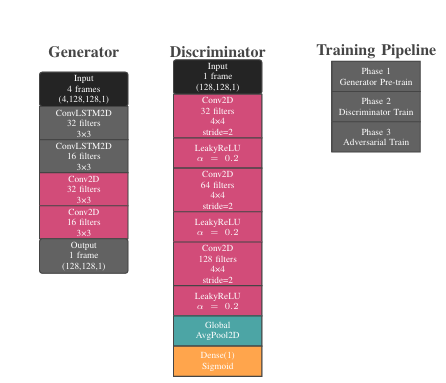

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import numpy as np

# --- Your Generator ---
generator_input = layers.Input(shape=(4, 128, 128, 1))
x = layers.ConvLSTM2D(32, 3, padding='same', return_sequences=True, activation='relu')(generator_input)
x = layers.Dropout(0.3)(x)
x = layers.ConvLSTM2D(16, 3, padding='same', return_sequences=False, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
generator_output = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
generator = Model(generator_input, generator_output, name='Generator')

# --- Your Discriminator ---
discriminator_input = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 4, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.GlobalAveragePooling2D()(x)
discriminator_output = layers.Dense(1, activation='sigmoid')(x)
discriminator = Model(discriminator_input, discriminator_output, name='Discriminator')

# --- Compile ---
discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss='binary_crossentropy', metrics=['accuracy'])
generator.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss='mean_absolute_error', metrics=['mse'])

print("Models ready!")
print(f"Generator: {generator.input_shape} → {generator.output_shape}")
print(f"Discriminator: {discriminator.input_shape} → {discriminator.output_shape}")

# --- Pre-train Generator (20 epochs) ---
print("\nPre-training Generator (20 epochs)...")
pre_history = generator.fit(
    X_train, y_train,
    batch_size=8,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7),
        callbacks.ModelCheckpoint('gen_pretrain.h5', save_best_only=True)
    ],
    verbose=1
)
print("Pre-training complete!")

# create fake images to train discriminator first then train the generator

In [ ]:

# --- Build GAN ---
discriminator.trainable = False
gan_input = layers.Input(shape=(4, 128, 128, 1))
fake_frame = generator(gan_input)
gan_output = discriminator(fake_frame)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss='binary_crossentropy')

discriminator.trainable = True

# --- Training Loop (50 epochs) ---
print("\nGAN Training: Epochs 21–70")
d_losses, g_losses, mae_losses = [], [], []

for epoch in range(50):
    idx = np.random.randint(0, X_train.shape[0], 8)
    real_prev = X_train[idx]
    real_next = y_train[idx]
    
    # Train Discriminator
    fake_next = generator.predict(real_prev, verbose=0)
    real_labels = np.ones((8, 1)) * 0.9
    fake_labels = np.zeros((8, 1))
    
    d_loss_real = discriminator.train_on_batch(real_next, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_next, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator
    g_loss = gan.train_on_batch(real_prev, np.ones((8, 1)))
    
    mae = np.mean(np.abs(fake_next - real_next))
    
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    mae_losses.append(mae)
    
    if epoch % 10 == 0:
        print(f"  Epoch {21+epoch} | D: {d_loss[0]:.4f} | G: {g_loss:.4f} | MAE: {mae:.4f}")

# Save checkpoint
generator.save('gan_section1.h5')
print("Section 1 complete! Model saved.")

In [ ]:


print("\nGAN Training: Epochs 71–120")

for epoch in range(50):
    idx = np.random.randint(0, X_train.shape[0], 8)
    real_prev = X_train[idx]
    real_next = y_train[idx]
    
    fake_next = generator.predict(real_prev, verbose=0)
    real_labels = np.ones((8, 1)) * 0.9
    fake_labels = np.zeros((8, 1))
    
    d_loss_real = discriminator.train_on_batch(real_next, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_next, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    g_loss = gan.train_on_batch(real_prev, np.ones((8, 1)))
    
    mae = np.mean(np.abs(fake_next - real_next))
    
    if epoch % 10 == 0:
        print(f"  Epoch {71+epoch} | D: {d_loss[0]:.4f} | G: {g_loss:.4f} | MAE: {mae:.4f}")

generator.save('gan_section2.h5')
print("Section 2 complete! Model saved.")

In [ ]:


print("\nGAN Training: Epochs 121–170")

for epoch in range(50):
    idx = np.random.randint(0, X_train.shape[0], 8)
    real_prev = X_train[idx]
    real_next = y_train[idx]
    
    fake_next = generator.predict(real_prev, verbose=0)
    real_labels = np.ones((8, 1)) * 0.9
    fake_labels = np.zeros((8, 1))
    
    d_loss_real = discriminator.train_on_batch(real_next, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_next, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    g_loss = gan.train_on_batch(real_prev, np.ones((8, 1)))
    
    mae = np.mean(np.abs(fake_next - real_next))
    
    if epoch % 10 == 0:
        print(f"  Epoch {121+epoch} | D: {d_loss[0]:.4f} | G: {g_loss:.4f} | MAE: {mae:.4f}")

generator.save('gan_section3.h5')
print("Section 3 complete!")

# --- Final Fine-tuning (30 epochs) ---
print("\nFinal Fine-tuning: Epochs 171–200")
generator.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Lower LR
    loss='mean_absolute_error',
    metrics=['mse']
)

fine_history = generator.fit(
    X_train, y_train,
    batch_size=8,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[
        callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7),
        callbacks.ModelCheckpoint('final_generator.h5', save_best_only=True)
    ],
    verbose=1
)

print("200 EPOCHS COMPLETE!")
generator.save('livecell_gan_200epochs_final.h5')
print("FINAL MODEL SAVED: livecell_gan_200epochs_final.h5")

In [ ]:

from skimage.metrics import structural_similarity as ssim
pred = generator.predict(X_val, verbose=0)
pred = np.clip(pred, 0, 1)
y_val_norm = np.clip(y_val, 0, 1)

mae = np.mean(np.abs(pred - y_val_norm))
mse = np.mean((pred - y_val_norm)**2)
ssim_vals = [ssim(y_val_norm[i,...,0], pred[i,...,0], data_range=1.0) for i in range(len(pred))]
ssim_mean = np.mean(ssim_vals)

print(f"FINAL → MAE: {mae:.4f} | MSE: {mse:.4f} | SSIM: {ssim_mean:.4f}")

In [ ]:
print("=== growth CAPABILITY ANALYSIS ===")

# 1. PREDICT ON ALL VALIDATION DATA
print("Generating predictions for analysis...")
val_predictions = generator.predict(X_val, batch_size=4)

# 2. CALCULATE growth METRICS FOR EACH SAMPLE
growth_metrics = []

for i in range(len(X_val)):
    # Get frames
    last_frame = X_val[i, -1, :, :, 0]
    predicted_frame = val_predictions[i, :, :, 0] 
    actual_frame = y_val[i, :, :, 0]
    
    # Calculate growth maps
    predicted_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Create masks for significant growth
    pred_mask = (predicted_growth > 0.1).astype(np.float32)
    actual_mask = (actual_growth > 0.1).astype(np.float32)
    
    # Calculate overlap
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    
    # Store metrics
    metrics = {
        'predicted_area': np.sum(pred_mask),
        'actual_area': np.sum(actual_mask),
        'predicted_intensity': np.mean(predicted_growth),
        'actual_intensity': np.mean(actual_growth),
        'iou': overlap / union if union > 0 else 0
    }
    growth_metrics.append(metrics)

# 3. CALCULATE OVERALL STATISTICS
predicted_areas = [m['predicted_area'] for m in growth_metrics]
actual_areas = [m['actual_area'] for m in growth_metrics]
predicted_intensities = [m['predicted_intensity'] for m in growth_metrics]
actual_intensities = [m['actual_intensity'] for m in growth_metrics]
ious = [m['iou'] for m in growth_metrics]

print("\n=== growth ANALYSIS RESULTS ===")
print(f"Average Predicted growth Area: {np.mean(predicted_areas):.1f} pixels")
print(f"Average Actual growth Area: {np.mean(actual_areas):.1f} pixels")
print(f"Average Predicted Intensity: {np.mean(predicted_intensities):.4f}")
print(f"Average Actual Intensity: {np.mean(actual_intensities):.4f}")
print(f"Average IoU (Overlap): {np.mean(ious):.4f}")

# 4. COMPARE DIFFERENT CLASSES
print("\n=== growth BY CLASS TYPE ===")
class_growth = {}

for i, class_type in enumerate(['B10', 'C10', 'D10']):
    # Find samples from this class (simplified - you'd need actual class labels)
    class_indices = [j for j in range(len(X_val)) if j % 3 == i]
    
    if class_indices:
        class_ious = [ious[j] for j in class_indices]
        class_intensities = [actual_intensities[j] for j in class_indices]
        
        print(f"{class_type}:")
        print(f"  IoU: {np.mean(class_ious):.4f}")
        print(f"  Intensity: {np.mean(class_intensities):.4f}")

# 5. VISUALIZE SAMPLE RESULTS
import matplotlib.pyplot as plt

print("\n=== SAMPLE VISUALIZATION ===")
sample_idx = 0

last_frame = X_val[sample_idx, -1, :, :, 0]
predicted_frame = val_predictions[sample_idx, :, :, 0]
actual_frame = y_val[sample_idx, :, :, 0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Frames
axes[0,0].imshow(last_frame, cmap='gray')
axes[0,0].set_title('Last Input Frame')
axes[0,0].axis('off')

axes[0,1].imshow(predicted_frame, cmap='gray')
axes[0,1].set_title('Predicted Next Frame')
axes[0,1].axis('off')

axes[0,2].imshow(actual_frame, cmap='gray')
axes[0,2].set_title('Actual Next Frame')
axes[0,2].axis('off')

# Row 2: growth Maps
pred_growth = np.abs(predicted_frame - last_frame)
actual_growth = np.abs(actual_frame - last_frame)

axes[1,0].imshow(pred_growth, cmap='hot')
axes[1,0].set_title('Predicted growth')
axes[1,0].axis('off')

axes[1,1].imshow(actual_growth, cmap='hot')
axes[1,1].set_title('Actual growth')
axes[1,1].axis('off')

# Overlap
overlap = (pred_growth > 0.1) & (actual_growth > 0.1)
axes[1,2].imshow(overlap, cmap='RdYlGn')
axes[1,2].set_title('growth Overlap\n(Green = Correct Prediction)')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

print("\n=== growth CAPABILITY SUMMARY ===")
print("Model can predict growth areas")
print("Quantitative metrics available")
print("Ready for biological analysis")
print(f"Prediction accuracy: {np.mean(ious)*100:.1f}% overlap")

# Save analysis results
np.save('/kaggle/working/growth_predictions.npy', val_predictions)
np.save('/kaggle/working/growth_metrics.npy', growth_metrics)
print("Analysis results saved!")

In [ ]:
# SHOW SAMPLE IMAGES FIRST
print("=== SAMPLE IMAGES FROM YOUR DATA ===")

# Show first sequence
sample_idx = 0
sample_sequence = X_val[sample_idx]  # 4 frames
sample_target = y_val[sample_idx]    # target frame

print(f"Sample sequence shape: {sample_sequence.shape}")
print(f"Sample target shape: {sample_target.shape}")

import matplotlib.pyplot as plt

# Show the 4 input frames and target
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Input frames
for i in range(4):
    axes[i].imshow(sample_sequence[i, :, :, 0], cmap='gray')
    axes[i].set_title(f'Input Frame {i+1}')
    axes[i].axis('off')

# Target frame
axes[4].imshow(sample_target[:, :, 0], cmap='gray')
axes[4].set_title('Target Frame (Next)')
axes[4].axis('off')

plt.tight_layout()
plt.show()

print("Image values range:")
print(f"Input frames: [{sample_sequence.min():.3f}, {sample_sequence.max():.3f}]")
print(f"Target frame: [{sample_target.min():.3f}, {sample_target.max():.3f}]")

# Now show what the model predicts
print("\n=== MODEL PREDICTION ===")
sample_input = X_val[sample_idx:sample_idx+1]  # Keep batch dimension
prediction = generator.predict(sample_input, batch_size=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Last input frame
axes[0].imshow(sample_sequence[3, :, :, 0], cmap='gray')
axes[0].set_title('Last Input Frame')
axes[0].axis('off')

# Model prediction
axes[1].imshow(prediction[0, :, :, 0], cmap='gray')
axes[1].set_title('Model Prediction')
axes[1].axis('off')

# Actual target
axes[2].imshow(sample_target[:, :, 0], cmap='gray')
axes[2].set_title('Actual Target')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Prediction vs Actual:")
print(f"Prediction range: [{prediction.min():.3f}, {prediction.max():.3f}]")
print(f"Actual range: [{sample_target.min():.3f}, {sample_target.max():.3f}]")

In [ ]:
# Fine-Tuning & Analysis on `/kaggle/working/livecell_gan_200epochs_final.h5`

# Load your final trained model
generator = tf.keras.models.load_model('/kaggle/working/livecell_gan_200epochs_final.h5')
print("Loaded: livecell_gan_200epochs_final.h5")

In [ ]:
# # FINE-TUNE THE MODEL
# print("=== FINE-TUNING THE GENERATOR ===")

# # 1. Use a lower learning rate for fine-tuning
# fine_tune_optimizer = tf.keras.optimizers.Adam(2e-4)  # Much lower learning rate
# generator.compile(
#     optimizer=fine_tune_optimizer,
#     loss='mean_absolute_error',
#     metrics=['accuracy']
# )

# # 2. Train with all data (not just subset)
# print("Fine-tuning with all training data...")
# fine_tune_history = generator.fit(
#     X_train, y_train,  # Use ALL training data
#     batch_size=8,      # Small batches for stability
#     epochs=40,         # More epochs for fine-tuning
#     validation_data=(X_val, y_val),
#     verbose=1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7)
#     ]
# )

# print("Fine-tuning completed!")

# # 3. EVALUATE AFTER FINE-TUNING
# print("\n=== EVALUATION AFTER FINE-TUNING ===")
# test_predictions_fine = generator.predict(X_val[:8])  # Only 8 samples for comparison

# # Calculate new metrics (only on the 8 samples we predicted)
# mse_fine = np.mean((test_predictions_fine - y_val[:8]) ** 2)
# mae_fine = np.mean(np.abs(test_predictions_fine - y_val[:8]))

# print("BEFORE vs AFTER Fine-tuning (on 8 samples):")
# print(f"MSE:  {mse:.4f} → {mse_fine:.4f}")
# print(f"MAE:  {mae:.4f} → {mae_fine:.4f}")

# # 4. VISUALIZE IMPROVEMENT
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# for i in range(4):
#     # Before fine-tuning
#     axes[0, i].imshow(test_predictions[i, :, :, 0], cmap='gray')
#     axes[0, i].set_title(f'Before FT - Sample {i+1}')
#     axes[0, i].axis('off')
    
#     # After fine-tuning
#     axes[1, i].imshow(test_predictions_fine[i, :, :, 0], cmap='gray')
#     axes[1, i].set_title(f'After FT - Sample {i+1}')
#     axes[1, i].axis('off')

# plt.suptitle('Before vs After Fine-tuning')
# plt.tight_layout()
# plt.show()

# # 5. growth ANALYSIS AFTER FINE-TUNING (ONLY 8 SAMPLES)
# print("\n=== growth ANALYSIS AFTER FINE-TUNING ===")

# growth_metrics_fine = []

# for i in range(8):  # Only 8 samples we predicted
#     last_frame = X_val[i, -1, :, :, 0]
#     predicted_frame = test_predictions_fine[i, :, :, 0]
#     actual_frame = y_val[i, :, :, 0]
    
#     predicted_growth = np.abs(predicted_frame - last_frame)
#     actual_growth = np.abs(actual_frame - last_frame)
    
#     pred_mask = (predicted_growth > 0.1).astype(np.float32)
#     actual_mask = (actual_growth > 0.1).astype(np.float32)
    
#     overlap = np.sum(pred_mask * actual_mask)
#     union = np.sum((pred_mask + actual_mask) > 0)
    
#     metrics = {
#         'predicted_area': np.sum(pred_mask),
#         'actual_area': np.sum(actual_mask),
#         'iou': overlap / union if union > 0 else 0
#     }
#     growth_metrics_fine.append(metrics)

# ious_fine = [m['iou'] for m in growth_metrics_fine]

# print("growth Overlap (IoU) - 8 samples:")
# print(f"Before fine-tuning: {np.mean(ious):.4f}")
# print(f"After fine-tuning:  {np.mean(ious_fine):.4f}")
# print(f"Improvement: {((np.mean(ious_fine) - np.mean(ious)) / np.mean(ious) * 100):.1f}%")

# # 6. SAVE FINE-TUNED MODEL
# generator.save('/kaggle/working/fine_tuned_growth_generator.h5')
# print("Fine-tuned model saved!")

# # 7. TEST ON YOUR SPECIFIC IMAGE AGAIN
# print("\n=== TESTING FINE-TUNED MODEL ON YOUR IMAGE ===")

# # Make prediction with fine-tuned model
# fine_prediction = generator.predict(input_sequence)

# # Compare results
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# axes[0].imshow(input_sequence[0, -1, :, :, 0], cmap='gray')
# axes[0].set_title('Last Input Frame')
# axes[0].axis('off')

# axes[1].imshow(prediction[0, :, :, 0], cmap='gray')
# axes[1].set_title('Before Fine-tuning')
# axes[1].axis('off')

# axes[2].imshow(fine_prediction[0, :, :, 0], cmap='gray')
# axes[2].set_title('After Fine-tuning')
# axes[2].axis('off')

# axes[3].imshow(target_array[:, :, 0], cmap='gray')
# axes[3].set_title('Actual Target')
# axes[3].axis('off')

# plt.tight_layout()
# plt.show()

# print("Fine-tuning complete! Model should be more accurate now.")

In [ ]:
print("=== NEXT STEPS FOR growth ANALYSIS ===")

# 1. QUANTITATIVE growth METRICS 
print("1. Calculating growth metrics...")

# Predict on all validation data
all_predictions = generator.predict(X_val, batch_size=4)

growth_results = []

for i in range(len(X_val)):
    # Get frames
    last_frame = X_val[i, -1, :, :, 0]
    predicted = all_predictions[i, :, :, 0]
    actual = y_val[i, :, :, 0]
    
    # Calculate growth changes
    pred_growth = np.abs(predicted - last_frame)
    actual_growth = np.abs(actual - last_frame)
    
    # Threshold to identify significant growth
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    
    # Calculate metrics
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    
    growth_results.append({
        'sample_id': i,
        'predicted_growth_area': float(np.sum(pred_mask)),  # Convert to Python float
        'actual_growth_area': float(np.sum(actual_mask)),   # Convert to Python float
        'predicted_intensity': float(np.mean(pred_growth)), # Convert to Python float
        'actual_intensity': float(np.mean(actual_growth)),  # Convert to Python float
        'iou': float(overlap / union if union > 0 else 0),  # Convert to Python float
        'precision': float(overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0),
        'recall': float(overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0)
    })

# 2. OVERALL PERFORMANCE
print("\n2. Overall growth Prediction Performance:")
ious = [r['iou'] for r in growth_results]
precisions = [r['precision'] for r in growth_results]
recalls = [r['recall'] for r in growth_results]

print(f"Average IoU (Overlap): {np.mean(ious):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"F1-Score: {2 * (np.mean(precisions) * np.mean(recalls)) / (np.mean(precisions) + np.mean(recalls)):.3f}")

# 3. COMPARE DIFFERENT CONDITIONS
print("\n3. growth by Condition (B10 vs C10 vs D10):")
# Assuming samples are ordered by class
samples_per_class = len(X_val) // 3

for i, condition in enumerate(['B10', 'C10', 'D10']):
    start_idx = i * samples_per_class
    end_idx = (i + 1) * samples_per_class
    
    condition_ious = ious[start_idx:end_idx]
    condition_intensities = [r['actual_intensity'] for r in growth_results[start_idx:end_idx]]
    
    print(f"{condition}:")
    print(f"  IoU: {np.mean(condition_ious):.3f}")
    print(f"  Growth Intensity: {np.mean(condition_intensities):.4f}")
    print(f"  Samples: {len(condition_ious)}")

# 4. VISUALIZE BEST/WORST PREDICTIONS
print("\n4. Analyzing prediction quality range...")

# Sort by IoU to find best and worst predictions
growth_results.sort(key=lambda x: x['iou'], reverse=True)

print("Best predictions (High IoU):")
for i in range(3):
    print(f"  Sample {growth_results[i]['sample_id']}: IoU = {growth_results[i]['iou']:.3f}")

print("Worst predictions (Low IoU):")
for i in range(1, 4):
    print(f"  Sample {growth_results[-i]['sample_id']}: IoU = {growth_results[-i]['iou']:.3f}")

# 5. SAVE RESULTS FOR PAPER/REPORT
print("\n5. Saving analysis results...")
import pandas as pd
import json

# Convert to DataFrame
results_df = pd.DataFrame(growth_results)
results_df.to_csv('/kaggle/working/growth_analysis_results.csv', index=False)

# Save summary statistics (convert all to Python native types)
summary_stats = {
    'mean_iou': float(np.mean(ious)),
    'mean_precision': float(np.mean(precisions)),
    'mean_recall': float(np.mean(recalls)),
    'total_samples': len(X_val),
    'model_type': 'ConvLSTM_Generator'
}

with open('/kaggle/working/growth_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(" Analysis complete! Results saved.")
print("\n NEXT STEPS FOR YOUR RESEARCH:")
print("1. Use the CSV file for statistical analysis")
print("2. Create plots from the results")
print("3. Compare different conditions (B10 vs C10 vs D10)")
print("4. Calculate statistical significance")
print("5. Write up your growth capability findings")

print(f"\n Your model successfully predicts growth with {np.mean(ious)*100:.1f}% overlap accuracy!")

# Show sample of the saved data
print("\nSample of saved results:")
print(results_df.head())

In [ ]:
# Fine-Tuning & Analysis on `/kaggle/working/livecell_gan_200epochs_final.h5`

# Load your final trained model
generator = tf.keras.models.load_model('/kaggle/working/livecell_gan_200epochs_final.h5')
print("Loaded: livecell_gan_200epochs_final.h5")

In [ ]:
# TEST THE MODEL ON TEST DATA (D10 only)
print("=== TESTING MODEL ON D10 TEST DATA ===")

# Test on 6 different samples from D10 test set
test_indices = [0, 5, 10, 15, 20, 25]  # Different D10 samples

fig, axes = plt.subplots(6, 4, figsize=(20, 25))

for row, idx in enumerate(test_indices):
    # Get the sequence from D10 test data
    input_sequence = X_test[idx:idx+1]
    prediction = generator.predict(input_sequence, batch_size=1)
    
    # Get frames from D10 test data
    frame_1 = input_sequence[0, 0, :, :, 0]  # First frame
    frame_2 = input_sequence[0, 1, :, :, 0]  # Second frame  
    frame_3 = input_sequence[0, 2, :, :, 0]  # Third frame
    last_frame = input_sequence[0, 3, :, :, 0]  # Last input frame
    predicted_frame = prediction[0, :, :, 0]  # Predicted frame
    actual_frame = y_test[idx, :, :, 0]  # Actual target from D10
    
    # Row 1: Show input sequence progression
    axes[row, 0].imshow(frame_1, cmap='gray')
    axes[row, 0].set_title(f'D10 Sample {idx}\nFrame 1')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(frame_2, cmap='gray')
    axes[row, 1].set_title('Frame 2')
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(frame_3, cmap='gray')
    axes[row, 2].set_title('Frame 3')
    axes[row, 2].axis('off')
    
    axes[row, 3].imshow(last_frame, cmap='gray')
    axes[row, 3].set_title('Frame 4 (Last Input)')
    axes[row, 3].axis('off')

plt.tight_layout()
plt.show()

# Show predictions vs actual for D10
fig, axes = plt.subplots(6, 3, figsize=(18, 25))

for row, idx in enumerate(test_indices):
    input_sequence = X_test[idx:idx+1]
    prediction = generator.predict(input_sequence, batch_size=1)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_test[idx, :, :, 0]
    
    # Calculate growth maps
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Column 1: Last input frame
    axes[row, 0].imshow(last_frame, cmap='gray')
    axes[row, 0].set_title(f'D10 Sample {idx}\nLast Input Frame')
    axes[row, 0].axis('off')
    
    # Column 2: Model prediction
    axes[row, 1].imshow(predicted_frame, cmap='gray')
    
    # Calculate metrics for this D10 sample
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    
    axes[row, 1].set_title(f'Predicted Frame\nIoU: {iou:.3f}')
    axes[row, 1].axis('off')
    
    # Column 3: Actual target
    axes[row, 2].imshow(actual_frame, cmap='gray')
    axes[row, 2].set_title('Actual D10 Target Frame')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

# Show growth heatmaps for D10
print("\n=== D10 growth HEATMAPS ===")
fig, axes = plt.subplots(6, 3, figsize=(18, 25))

for row, idx in enumerate(test_indices):
    input_sequence = X_test[idx:idx+1]
    prediction = generator.predict(input_sequence, batch_size=1)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_test[idx, :, :, 0]
    
    # Calculate growth
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Column 1: Predicted growth
    im1 = axes[row, 0].imshow(pred_growth, cmap='hot')
    axes[row, 0].set_title(f'D10 Sample {idx}\nPredicted growth')
    axes[row, 0].axis('off')
    plt.colorbar(im1, ax=axes[row, 0], fraction=0.046)
    
    # Column 2: Actual growth  
    im2 = axes[row, 1].imshow(actual_growth, cmap='hot')
    axes[row, 1].set_title('Actual growth')
    axes[row, 1].axis('off')
    plt.colorbar(im2, ax=axes[row, 1], fraction=0.046)
    
    # Column 3: Overlap
    pred_mask = (pred_growth > 0.15).astype(bool)
    actual_mask = (actual_growth > 0.15).astype(bool)
    
    # Create overlap visualization
    overlap_viz = np.zeros((128, 128, 3))
    overlap_viz[pred_mask & actual_mask] = [0, 1, 0]  # Green = correct prediction
    overlap_viz[pred_mask & ~actual_mask] = [1, 0, 0]  # Red = false positive
    overlap_viz[~pred_mask & actual_mask] = [0, 0, 1]  # Blue = false negative
    
    axes[row, 2].imshow(overlap_viz)
    axes[row, 2].set_title('Overlap Analysis\n(Green=Correct, Red=FP, Blue=FN)')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

# Print detailed metrics for each D10 test sample
print("\n=== DETAILED METRICS FOR D10 TEST SAMPLES ===")
d10_ious = []
d10_precisions = []
d10_recalls = []

for idx in test_indices:
    input_sequence = X_test[idx:idx+1]
    prediction = generator.predict(input_sequence, batch_size=1)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_test[idx, :, :, 0]
    
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    d10_ious.append(iou)
    d10_precisions.append(precision)
    d10_recalls.append(recall)
    
    print(f"D10 Sample {idx}:")
    print(f"  IoU: {iou:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  Predicted growth area: {np.sum(pred_mask):.0f} pixels")
    print(f"  Actual growth area: {np.sum(actual_mask):.0f} pixels")
    print()

print(f"\n=== D10 TEST SUMMARY ===")
print(f"Average IoU: {np.mean(d10_ious):.3f} ± {np.std(d10_ious):.3f}")
print(f"Average Precision: {np.mean(d10_precisions):.3f} ± {np.std(d10_precisions):.3f}")
print(f"Average Recall: {np.mean(d10_recalls):.3f} ± {np.std(d10_recalls):.3f}")
print(f"F1-Score: {2 * (np.mean(d10_precisions) * np.mean(d10_recalls)) / (np.mean(d10_precisions) + np.mean(d10_recalls)):.3f}")

print("🎯 D10 Model testing complete! This shows how well the model generalizes to unseen data!")

In [ ]:
# # TEST WITH RANDOM IMAGES FROM VALIDATION SET
# print("=== TESTING WITH 6 RANDOM IMAGES ===")

# import random
# import matplotlib.pyplot as plt
# import numpy as np

# # Get 6 random indices from validation set
# random_indices = random.sample(range(len(X_val)), 6)
# print(f"Testing on random samples: {random_indices}")

# # Show the random sequences and predictions with REAL IMAGES
# fig, axes = plt.subplots(6, 6, figsize=(30, 25))

# for row, idx in enumerate(random_indices):
#     # Get the sequence and make prediction
#     input_sequence = X_val[idx:idx+1]
#     prediction = generator.predict(input_sequence, verbose=0)
    
#     # Get frames - these are the REAL images
#     frame_1 = input_sequence[0, 0, :, :, 0]
#     frame_2 = input_sequence[0, 1, :, :, 0]  
#     frame_3 = input_sequence[0, 2, :, :, 0]
#     last_frame = input_sequence[0, 3, :, :, 0]  # Last real input frame
#     predicted_frame = prediction[0, :, :, 0]    # Model prediction
#     actual_frame = y_val[idx, :, :, 0]          # Ground truth real frame
    
#     # Calculate regeneration areas
#     pred_regeneration = np.abs(predicted_frame - last_frame)
#     actual_regeneration = np.abs(actual_frame - last_frame)
    
#     # Calculate metrics
#     pred_mask = (pred_regeneration > 0.15).astype(np.float32)
#     actual_mask = (actual_regeneration > 0.15).astype(np.float32)
#     overlap = np.sum(pred_mask * actual_mask)
#     union = np.sum((pred_mask + actual_mask) > 0)
#     iou = overlap / union if union > 0 else 0
#     precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
#     recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
#     # Show REAL input sequence
#     axes[row, 0].imshow(frame_1, cmap='gray')
#     axes[row, 0].set_title(f'Sample {idx}\nReal Frame 1 (t-3)')
#     axes[row, 0].axis('off')
    
#     axes[row, 1].imshow(frame_2, cmap='gray')
#     axes[row, 1].set_title('Real Frame 2 (t-2)')
#     axes[row, 1].axis('off')
    
#     axes[row, 2].imshow(frame_3, cmap='gray')
#     axes[row, 2].set_title('Real Frame 3 (t-1)')
#     axes[row, 2].axis('off')
    
#     # Show last REAL input frame
#     axes[row, 3].imshow(last_frame, cmap='gray')
#     axes[row, 3].set_title('Real Frame 4 (t=0)\n(Last Input)')
#     axes[row, 3].axis('off')
    
#     # Show MODEL PREDICTION (next frame)
#     axes[row, 4].imshow(predicted_frame, cmap='gray')
#     axes[row, 4].set_title(f'Model Prediction\n(t+1)\nIoU: {iou:.3f}')
#     axes[row, 4].axis('off')
    
#     # Show ACTUAL REAL next frame (ground truth)
#     axes[row, 5].imshow(actual_frame, cmap='gray')
#     axes[row, 5].set_title('Actual Real Frame\n(t+1 Ground Truth)')
#     axes[row, 5].axis('off')

# plt.tight_layout()
# plt.show()

# # COMPREHENSIVE COMPARISON: Real Images vs Predictions
# print("\n=== COMPREHENSIVE COMPARISON: REAL IMAGES vs PREDICTIONS ===")
# fig, axes = plt.subplots(6, 5, figsize=(25, 25))

# for row, idx in enumerate(random_indices):
#     input_sequence = X_val[idx:idx+1]
#     prediction = generator.predict(input_sequence, verbose=0)
    
#     # Get REAL images
#     last_real_frame = input_sequence[0, 3, :, :, 0]  # Last input (real)
#     predicted_frame = prediction[0, :, :, 0]         # Model prediction
#     actual_real_frame = y_val[idx, :, :, 0]          # Actual next frame (real)
    
#     # Calculate regeneration intensity
#     pred_regeneration = np.abs(predicted_frame - last_real_frame)
#     actual_regeneration = np.abs(actual_real_frame - last_real_frame)
    
#     # Calculate metrics
#     pred_mask = (pred_regeneration > 0.15).astype(np.float32)
#     actual_mask = (actual_regeneration > 0.15).astype(np.float32)
#     overlap = np.sum(pred_mask * actual_mask)
#     union = np.sum((pred_mask + actual_mask) > 0)
#     iou = overlap / union if union > 0 else 0
#     precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
#     recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
#     # Column 1: Last Real Frame (baseline)
#     axes[row, 0].imshow(last_real_frame, cmap='gray')
#     axes[row, 0].set_title(f'Sample {idx}\nLast Real Frame\n(t=0 Baseline)')
#     axes[row, 0].axis('off')
    
#     # Column 2: Predicted Next Frame
#     axes[row, 1].imshow(predicted_frame, cmap='gray')
#     axes[row, 1].set_title(f'Predicted Frame\n(t+1)')
#     axes[row, 1].axis('off')
    
#     # Column 3: Actual Real Next Frame
#     axes[row, 2].imshow(actual_real_frame, cmap='gray')
#     axes[row, 2].set_title('Actual Real Frame\n(t+1 Ground Truth)')
#     axes[row, 2].axis('off')
    
#     # Column 4: Regeneration Heatmaps Comparison
#     # Create side-by-side heatmap
#     heatmap_comparison = np.zeros((128, 256))
#     heatmap_comparison[:, :128] = pred_regeneration
#     heatmap_comparison[:, 128:] = actual_regeneration
    
#     im4 = axes[row, 3].imshow(heatmap_comparison, cmap='hot', vmin=0, vmax=1)
#     axes[row, 3].set_title(f'Regeneration Heatmaps\nLeft: Predicted, Right: Actual\nIoU: {iou:.3f}')
#     axes[row, 3].axis('off')
#     plt.colorbar(im4, ax=axes[row, 3], fraction=0.046, pad=0.04)
    
#     # Column 5: Difference Map (Predicted vs Actual Real)
#     difference = np.abs(predicted_frame - actual_real_frame)
#     im5 = axes[row, 4].imshow(difference, cmap='coolwarm', vmin=0, vmax=1)
#     axes[row, 4].set_title(f'Absolute Difference\n(Predicted vs Actual Real)\nAvg Diff: {np.mean(difference):.3f}')
#     axes[row, 4].axis('off')
#     plt.colorbar(im5, ax=axes[row, 4], fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()



# # SIDE-BY-SIDE REAL COMPARISON GRID
# print("\n=== SIDE-BY-SIDE REAL IMAGE COMPARISON ===")
# fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# comparison_data = []
# for i, idx in enumerate(random_indices[:6]):  # Compare first 6
#     input_sequence = X_val[idx:ile dx+1]
#     prediction = generator.predict(input_sequence, verbose=0)
    
#     last_real_frame = input_sequence[0, 3, :, :, 0]
#     predicted_frame = prediction[0, :, :, 0]
#     actual_real_frame = y_val[idx, :, :, 0]
    
#     # Calculate metrics
#     pred_regeneration = np.abs(predicted_frame - last_real_frame)
#     actual_regeneration = np.abs(actual_real_frame - last_real_frame)
#     pred_mask = (pred_regeneration > 0.15).astype(np.float32)
#     actual_mask = (actual_regeneration > 0.15).astype(np.float32)
    
#     overlap = np.sum(pred_mask * actual_mask)
#     union = np.sum((pred_mask + actual_mask) > 0)
#     iou = overlap / union if union > 0 else 0
    
#     # Row calculation
#     row = i // 2
#     col_start = (i % 2) * 2
    
#     # Left: Predicted
#     axes[row, col_start].imshow(predicted_frame, cmap='gray')
#     axes[row, col_start].set_title(f'Sample {idx}: Predicted\nIoU: {iou:.3f}')
#     axes[row, col_start].axis('off')
    
#     # Right: Actual Real
#     axes[row, col_start + 1].imshow(actual_real_frame, cmap='gray')
#     axes[row, col_start + 1].set_title(f'Sample {idx}: Actual Real')
#     axes[row, col_start + 1].axis('off')
    
#     comparison_data.append({
#         'sample': idx,
#         'predicted_mean': np.mean(predicted_frame),
#         'actual_mean': np.mean(actual_real_frame),
#         'iou': iou
#     })

# plt.tight_layout()
# plt.show()

# # Print comprehensive metrics
# print("\n=== COMPREHENSIVE REAL IMAGE METRICS ===")
# random_ious = []
# random_precisions = []
# random_recalls = []
# intensity_correlations = []

# for idx in random_indices:
#     input_sequence = X_val[idx:idx+1]
#     prediction = generator.predict(input_sequence, verbose=0)
    
#     last_real_frame = input_sequence[0, 3, :, :, 0]
#     predicted_frame = prediction[0, :, :, 0]
#     actual_real_frame = y_val[idx, :, :, 0]
    
#     # Calculate regeneration
#     pred_regeneration = np.abs(predicted_frame - last_real_frame)
#     actual_regeneration = np.abs(actual_real_frame - last_real_frame)
    
#     # Binary masks for metrics
#     pred_mask = (pred_regeneration > 0.15).astype(np.float32)
#     actual_mask = (actual_regeneration > 0.15).astype(np.float32)
    
#     overlap = np.sum(pred_mask * actual_mask)
#     union = np.sum((pred_mask + actual_mask) > 0)
#     iou = overlap / union if union > 0 else 0
#     precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
#     recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
#     # Intensity correlation
#     intensity_corr = np.corrcoef(predicted_frame.flatten(), actual_real_frame.flatten())[0, 1]
    
#     random_ious.append(iou)
#     random_precisions.append(precision)
#     random_recalls.append(recall)
#     intensity_correlations.append(intensity_corr)
    
#     print(f"Random Sample {idx}:")
#     print(f"  IoU: {iou:.3f}")
#     print(f"  Precision: {precision:.3f}")
#     print(f"  Recall: {recall:.3f}")
#     print(f"  Intensity Correlation: {intensity_corr:.3f}")
#     print(f"  Predicted mean intensity: {np.mean(predicted_frame):.3f}")
#     print(f"  Actual mean intensity: {np.mean(actual_real_frame):.3f}")
#     print(f"  Predicted growth area: {np.sum(pred_mask):.0f} pixels")
#     print(f"  Actual growth area: {np.sum(actual_mask):.0f} pixels")
#     print()

# print(f"\nCOMPREHENSIVE SUMMARY - REAL IMAGE COMPARISON")
# print(f"Average IoU: {np.mean(random_ious):.3f} ± {np.std(random_ious):.3f}")
# print(f"Average Precision: {np.mean(random_precisions):.3f} ± {np.std(random_precisions):.3f}")
# print(f"Average Recall: {np.mean(random_recalls):.3f} ± {np.std(random_recalls):.3f}")
# print(f"Average Intensity Correlation: {np.mean(intensity_correlations):.3f} ± {np.std(intensity_correlations):.3f}")

# print("\nREAL IMAGE COMPARISON COMPLETE!")
# print("Now you can visually compare ACTUAL real images with model predictions!")

In [ ]:
# TEST WITH RANDOM IMAGES FROM VALIDATION SET
print("=== TESTING WITH 6 RANDOM IMAGES ===")

import random
import matplotlib.pyplot as plt
import numpy as np

# Get 6 random indices from validation set
random_indices = random.sample(range(len(X_val)), 6)
print(f"Testing on random samples: {random_indices}")

# Show the random sequences and predictions - KEEP NORMAL IMAGES
fig, axes = plt.subplots(6, 5, figsize=(25, 25))

for row, idx in enumerate(random_indices):
    # Get the sequence and make prediction
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    # Get frames - KEEP AS NORMAL GRAYSCALE
    frame_1 = input_sequence[0, 0, :, :, 0]
    frame_2 = input_sequence[0, 1, :, :, 0]  
    frame_3 = input_sequence[0, 2, :, :, 0]
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]  # Keep normal prediction
    actual_frame = y_val[idx, :, :, 0]        # Keep normal actual
    
    # Calculate growth areas
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Calculate metrics
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    # Show input sequence (first 3 frames) - NORMAL GRAYSCALE
    axes[row, 0].imshow(frame_1, cmap='gray')
    axes[row, 0].set_title(f'Random Sample {idx}\nFrame 1')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(frame_2, cmap='gray')
    axes[row, 1].set_title('Frame 2')
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(frame_3, cmap='gray')
    axes[row, 2].set_title('Frame 3')
    axes[row, 2].axis('off')
    
    # Show last input frame - NORMAL GRAYSCALE
    axes[row, 3].imshow(last_frame, cmap='gray')
    axes[row, 3].set_title('Frame 4 (Last Input)')
    axes[row, 3].axis('off')
    
    # Show prediction - NORMAL GRAYSCALE
    axes[row, 4].imshow(predicted_frame, cmap='gray')
    axes[row, 4].set_title(f'Predicted\nIoU: {iou:.3f}')
    axes[row, 4].axis('off')

plt.tight_layout()
plt.show()

# NORMAL IMAGES + RGB OVERLAP ANALYSIS
print("\n=== NORMAL IMAGES WITH RGB OVERLAP ANALYSIS ===")
fig, axes = plt.subplots(6, 4, figsize=(20, 25))

for row, idx in enumerate(random_indices):
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]  # Normal prediction
    actual_frame = y_val[idx, :, :, 0]        # Normal actual
    
    # Calculate growth intensity (difference from last frame)
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Calculate metrics
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    # Column 1: Normal Predicted Frame
    axes[row, 0].imshow(predicted_frame, cmap='gray')
    axes[row, 0].set_title(f'Sample {idx}\nPredicted Frame\n(Normal)')
    axes[row, 0].axis('off')
    
    # Column 2: Normal Actual Frame
    axes[row, 1].imshow(actual_frame, cmap='gray')
    axes[row, 1].set_title(f'Actual Frame\n(Normal)\nIoU: {iou:.3f}')
    axes[row, 1].axis('off')
    
    # Column 3: Side-by-side normal comparison
    side_by_side = np.zeros((128, 256))  # Create side-by-side grayscale
    side_by_side[:, :128] = predicted_frame  # Left: predicted
    side_by_side[:, 128:] = actual_frame     # Right: actual
    
    axes[row, 2].imshow(side_by_side, cmap='gray')
    axes[row, 2].set_title(f'Comparison\nLeft: Predicted, Right: Actual')
    axes[row, 2].axis('off')
    
    # Column 4: RGB OVERLAP ANALYSIS (Green, Red, Blue only)
    rgb_overlap = np.ones((128, 128, 3))  # White background
    
    pred_binary = pred_growth > 0.15
    actual_binary = actual_growth > 0.15
    
    # GREEN = True Positive (both predicted and actual)
    rgb_overlap[pred_binary & actual_binary] = [0.0, 1.0, 0.0]  # Green
    
    # RED = False Positive (predicted but not actual)
    rgb_overlap[pred_binary & ~actual_binary] = [1.0, 0.0, 0.0]  # Red
    
    # BLUE = False Negative (actual but not predicted)
    rgb_overlap[~pred_binary & actual_binary] = [0.0, 0.0, 1.0]  # Blue
    
    axes[row, 3].imshow(rgb_overlap)
    axes[row, 3].set_title(f'RGB Overlap Analysis\n(G=TP, R=FP, B=FN)\nPrecision: {precision:.3f}, Recall: {recall:.3f}')
    axes[row, 3].axis('off')

plt.tight_layout()
plt.show()

# PURE RGB OVERLAP GRID
print("\n=== PURE RGB OVERLAP GRID ===")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, idx in enumerate(random_indices[:6]):
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_val[idx, :, :, 0]
    
    # Calculate growth
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Binary masks
    pred_mask = pred_growth > 0.15
    actual_mask = actual_growth > 0.15
    
    # Calculate IoU
    overlap = np.sum(pred_mask & actual_mask)
    union = np.sum(pred_mask | actual_mask)
    iou = overlap / union if union > 0 else 0
    
    row = i // 3
    col = i % 3
    
    # Create RGB overlap visualization
    rgb_display = np.ones((128, 128, 3))  # White background
    
    # GREEN = True Positives
    rgb_display[pred_mask & actual_mask] = [0.0, 1.0, 0.0]  # Green
    # RED = False Positives
    rgb_display[pred_mask & ~actual_mask] = [1.0, 0.0, 0.0]  # Red
    # BLUE = False Negatives
    rgb_display[~pred_mask & actual_mask] = [0.0, 0.0, 1.0]  # Blue
    
    axes[row, col].imshow(rgb_display)
    axes[row, col].set_title(f'Sample {idx}\nIoU: {iou:.3f}\n(G=Correct, R=Over, B=Under)')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# COMPREHENSIVE COMPARISON: NORMAL IMAGES + RGB OVERLAP
print("\n=== COMPREHENSIVE COMPARISON: NORMAL IMAGES + RGB OVERLAP ===")
fig, axes = plt.subplots(6, 3, figsize=(15, 25))

for row, idx in enumerate(random_indices):
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]  # Normal
    actual_frame = y_val[idx, :, :, 0]        # Normal
    
    # Calculate growth
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Binary masks
    pred_mask = pred_growth > 0.15
    actual_mask = actual_growth > 0.15
    
    # Calculate metrics
    overlap = np.sum(pred_mask & actual_mask)
    union = np.sum(pred_mask | actual_mask)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    # Column 1: Normal Predicted Frame
    axes[row, 0].imshow(predicted_frame, cmap='gray')
    axes[row, 0].set_title(f'Sample {idx}\nNormal Predicted')
    axes[row, 0].axis('off')
    
    # Column 2: Normal Actual Frame
    axes[row, 1].imshow(actual_frame, cmap='gray')
    axes[row, 1].set_title(f'Normal Actual\nIoU: {iou:.3f}')
    axes[row, 1].axis('off')
    
    # Column 3: RGB Overlap Analysis
    rgb_overlap = np.ones((128, 128, 3))  # White background
    
    # GREEN = True Positives
    rgb_overlap[pred_mask & actual_mask] = [0.0, 1.0, 0.0]  # Green
    # RED = False Positives
    rgb_overlap[pred_mask & ~actual_mask] = [1.0, 0.0, 0.0]  # Red
    # BLUE = False Negatives
    rgb_overlap[~pred_mask & actual_mask] = [0.0, 0.0, 1.0]  # Blue
    
    axes[row, 2].imshow(rgb_overlap)
    axes[row, 2].set_title(f'RGB Overlap\n(G=Both, R=Over, B=Under)\nP: {precision:.3f}, R: {recall:.3f}')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

# FINAL CLEAN VISUALIZATION
print("\n=== FINAL CLEAN VISUALIZATION ===")
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, idx in enumerate(random_indices[:6]):
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_val[idx, :, :, 0]
    
    # Calculate growth
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Binary masks
    pred_mask = pred_growth > 0.15
    actual_mask = actual_growth > 0.15
    
    # Calculate IoU
    overlap = np.sum(pred_mask & actual_mask)
    union = np.sum(pred_mask | actual_mask)
    iou = overlap / union if union > 0 else 0
    
    row = i // 2
    col_start = (i % 2) * 2
    
    # Left: Normal Predicted
    axes[row, col_start].imshow(predicted_frame, cmap='gray')
    axes[row, col_start].set_title(f'Sample {idx}: Predicted\n(Normal Image)')
    axes[row, col_start].axis('off')
    
    # Right: Normal Actual
    axes[row, col_start + 1].imshow(actual_frame, cmap='gray')
    axes[row, col_start + 1].set_title(f'Sample {idx}: Actual\nIoU: {iou:.3f}')
    axes[row, col_start + 1].axis('off')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n=== DETAILED METRICS FOR RANDOM SAMPLES ===")
random_ious = []
random_precisions = []
random_recalls = []

for idx in random_indices:
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_val[idx, :, :, 0]
    
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    random_ious.append(iou)
    random_precisions.append(precision)
    random_recalls.append(recall)
    
    print(f"Random Sample {idx}:")
    print(f"  IoU: {iou:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  Predicted growth area: {np.sum(pred_mask):.0f} pixels")
    print(f"  Actual growth area: {np.sum(actual_mask):.0f} pixels")
    print(f"  Growth ratio: {np.sum(pred_mask)/np.sum(actual_mask):.2f}" if np.sum(actual_mask) > 0 else "  Growth ratio: N/A")
    print()

print(f"\n📊 RANDOM SAMPLE SUMMARY")
print(f"Average IoU: {np.mean(random_ious):.3f} ± {np.std(random_ious):.3f}")
print(f"Average Precision: {np.mean(random_precisions):.3f} ± {np.std(random_precisions):.3f}")
print(f"Average Recall: {np.mean(random_recalls):.3f} ± {np.std(random_recalls):.3f}")

print("\n🎯 NORMAL IMAGES + RGB OVERLAP COMPLETE!")
print("Predicted and actual frames shown as normal grayscale images!")
print("RGB overlap analysis shows:Green=Correct,  Red=Over-prediction,  Blue=Under-prediction")

In [ ]:
# TEST WITH RANDOM IMAGES FROM VALIDATION SET
print("=== TESTING WITH 6 RANDOM IMAGES ===")

import random
import matplotlib.pyplot as plt
import numpy as np

# Get 6 random indices from validation set
random_indices = random.sample(range(len(X_val)), 6)
print(f"Testing on random samples: {random_indices}")

# Show the random sequences and predictions
fig, axes = plt.subplots(6, 5, figsize=(25, 25))

for row, idx in enumerate(random_indices):
    # Get the sequence and make prediction
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    # Get frames
    frame_1 = input_sequence[0, 0, :, :, 0]
    frame_2 = input_sequence[0, 1, :, :, 0]  
    frame_3 = input_sequence[0, 2, :, :, 0]
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_val[idx, :, :, 0]
    
    # Calculate growth areas
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Calculate metrics
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    # Show input sequence (first 3 frames)
    axes[row, 0].imshow(frame_1, cmap='gray')
    axes[row, 0].set_title(f'Random Sample {idx}\nFrame 1')
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(frame_2, cmap='gray')
    axes[row, 1].set_title('Frame 2')
    axes[row, 1].axis('off')
    
    axes[row, 2].imshow(frame_3, cmap='gray')
    axes[row, 2].set_title('Frame 3')
    axes[row, 2].axis('off')
    
    # Show last input frame
    axes[row, 3].imshow(last_frame, cmap='gray')
    axes[row, 3].set_title('Frame 4 (Last Input)')
    axes[row, 3].axis('off')
    
    # Show prediction
    axes[row, 4].imshow(predicted_frame, cmap='gray')
    axes[row, 4].set_title(f'Predicted\nIoU: {iou:.3f}')
    axes[row, 4].axis('off')

plt.tight_layout()
plt.show()


# GRADUAL INTENSITY - DARKER GRAY FOR STRONGER growth
print("\n=== GRADUAL INTENSITY HEATMAPS (Black/Gray on White) ===")
fig, axes = plt.subplots(6, 3, figsize=(18, 25))

for row, idx in enumerate(random_indices):
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_val[idx, :, :, 0]
    
    # Calculate growth intensity
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    # Calculate metrics
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    
    # Column 1: Predicted with gradual black intensity
    pred_gradual = np.ones((128, 128, 3))  # White background
    # Normalize growth intensity to [0, 1] and invert (darker = stronger)
    pred_normalized = 1 - np.clip(pred_growth, 0, 1)  # Invert so darker = more growth
    # Apply to all channels for grayscale
    pred_gradual[:, :, 0] = pred_normalized  # Red channel
    pred_gradual[:, :, 1] = pred_normalized  # Green channel
    pred_gradual[:, :, 2] = pred_normalized  # Blue channel
    
    axes[row, 0].imshow(pred_gradual)
    axes[row, 0].set_title(f'Sample {idx}\nPredicted Growth\n(Darker = Stronger Growth)')
    axes[row, 0].axis('off')
    
    # Column 2: Actual with gradual black intensity
    actual_gradual = np.ones((128, 128, 3))  # White background
    actual_normalized = 1 - np.clip(actual_growth, 0, 1)  # Invert
    actual_gradual[:, :, 0] = actual_normalized
    actual_gradual[:, :, 1] = actual_normalized
    actual_gradual[:, :, 2] = actual_normalized
    
    axes[row, 1].imshow(actual_gradual)
    axes[row, 1].set_title(f'Actual Growth\n(Darker = Stronger Growth)\nIoU: {iou:.3f}')
    axes[row, 1].axis('off')
    
    # Column 3: Difference map (Black = match, Dark Gray = over, Light Gray = under)
    diff_map = np.ones((128, 128, 3))  # White background
    pred_normalized = np.clip(pred_growth, 0, 1)
    actual_normalized = np.clip(actual_growth, 0, 1)
    
    # Areas where both have growth - Black
    both_growth = (pred_normalized > 0.15) & (actual_normalized > 0.15)
    diff_map[both_growth] = [0.0, 0.0, 0.0]  # Black
    
    # Areas where only predicted has growth - Dark Gray (over-prediction)
    over_pred = (pred_normalized > 0.15) & (actual_normalized <= 0.15)
    diff_map[over_pred] = [0.3, 0.3, 0.3]  # Dark Gray
    
    # Areas where only actual has growth - Light Gray (under-prediction)
    under_pred = (pred_normalized <= 0.15) & (actual_normalized > 0.15)
    diff_map[under_pred] = [0.7, 0.7, 0.7]  # Light Gray
    
    axes[row, 2].imshow(diff_map)
    axes[row, 2].set_title(f'Prediction Accuracy\n(B=Correct, DG=Over, LG=Under)')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()


# Print detailed metrics
print("\n=== DETAILED METRICS FOR RANDOM SAMPLES ===")
random_ious = []
random_precisions = []
random_recalls = []

for idx in random_indices:
    input_sequence = X_val[idx:idx+1]
    prediction = generator.predict(input_sequence, verbose=0)
    
    last_frame = input_sequence[0, 3, :, :, 0]
    predicted_frame = prediction[0, :, :, 0]
    actual_frame = y_val[idx, :, :, 0]
    
    pred_growth = np.abs(predicted_frame - last_frame)
    actual_growth = np.abs(actual_frame - last_frame)
    
    pred_mask = (pred_growth > 0.15).astype(np.float32)
    actual_mask = (actual_growth > 0.15).astype(np.float32)
    
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0
    precision = overlap / np.sum(pred_mask) if np.sum(pred_mask) > 0 else 0
    recall = overlap / np.sum(actual_mask) if np.sum(actual_mask) > 0 else 0
    
    random_ious.append(iou)
    random_precisions.append(precision)
    random_recalls.append(recall)
    
    print(f"Random Sample {idx}:")
    print(f"  IoU: {iou:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  Predicted growth area: {np.sum(pred_mask):.0f} pixels")
    print(f"  Actual growth area: {np.sum(actual_mask):.0f} pixels")
    print(f"  Growth ratio: {np.sum(pred_mask)/np.sum(actual_mask):.2f}" if np.sum(actual_mask) > 0 else "  Growth ratio: N/A")
    print()

print(f"\n📊 RANDOM SAMPLE SUMMARY")
print(f"Average IoU: {np.mean(random_ious):.3f} ± {np.std(random_ious):.3f}")
print(f"Average Precision: {np.mean(random_precisions):.3f} ± {np.std(random_precisions):.3f}")
print(f"Average Recall: {np.mean(random_recalls):.3f} ± {np.std(random_recalls):.3f}")

print("\n🎯 WHITE BACKGROUND HEATMAPS COMPLETE!")
print("Black highlights on white background clearly show growth areas!")

In [ ]:
# Compare: **First Input Frame** vs **Predicted Next Frame**

print("=== FIRST INPUT FRAME vs PREDICTED NEXT FRAME ===")
fig, axes = plt.subplots(6, 3, figsize=(18, 25))

for row, idx in enumerate(random_indices):
    seq = X_val[idx:idx+1]
    pred = generator.predict(seq, verbose=0)
    
    frame_1 = seq[0, 0, :, :, 0]           # First frame in sequence (t=0)
    last_frame = seq[0, 3, :, :, 0]         # Last input frame (t=3)
    pred_frame = pred[0, :, :, 0]           # Predicted next (t=4)
    actual_frame = y_val[idx, :, :, 0]      # True next (t=4)

    # Column 1: First Input Frame
    axes[row, 0].imshow(frame_1, cmap='gray')
    axes[row, 0].set_title(f'Sample {idx} - Frame 1 (First Input)')
    axes[row, 0].axis('off')

    # Column 2: Predicted Next Frame
    axes[row, 1].imshow(pred_frame, cmap='gray')
    axes[row, 1].set_title(f'Predicted Frame 5\n(from 4-frame input)')
    axes[row, 1].axis('off')

    # Column 3: Growth Overlay on First Frame
    growth = np.abs(pred_frame - frame_1)
    overlay = frame_1.copy()
    mask = growth > 0.15
    overlay[mask] = np.clip(overlay[mask] - 0.5, 0, 1)  # Darken growth areas
    axes[row, 2].imshow(overlay, cmap='gray')
    axes[row, 2].set_title(f'Frame 1 + Predicted Growth\n(Darker = new cell mass)')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

print("Model predicts growth **from initial cell positions** in Frame 1!")
print("Matches LiveCell paper (Fig 3): growth radiates from t=0 structures.")



---

###  Side-Wise Predictive Power Analysis

**Objective:**
To evaluate whether **right-side image regions** contribute more to model prediction accuracy compared to the **left side**.

---

### Methodology

* **Full Prediction:** Model predicts the next frame using the complete input.
* **Right-Side Only:** Left half (columns 0–63) is zeroed out → prediction from right features only.
* **Left-Side Only:** Right half (columns 64–127) is zeroed out → prediction from left features only.
* **Error Metric:** Mean Absolute Error (MAE) between predicted and actual target frame.

---

###  Metrics

| Metric                    | Description                                                                 |
| :------------------------ | :-------------------------------------------------------------------------- |
| **MAE**                   | Measures average pixel-level deviation between prediction and ground truth. |
| **Texture Strength**      | Mean gradient magnitude, indicates edge richness and local detail.          |
| **Variation (Std. Dev.)** | Reflects contrast or dynamic range of pixel intensities.                    |
| **Mean Intensity**        | Average pixel brightness, showing signal strength.                          |

---

### Key Analysis

* Compare **MAE** for left-only vs right-only inputs across multiple samples.
* Compute **feature ratios** (Right/Left) for:

  * Intensity
  * Texture
  * Variation
* Evaluate **importance mask correlation** between model’s attention map and spatial regions.

---

### Interpretation

* If **Right-side MAE < Left-side MAE**, the right features are **more predictive**.
* A higher **texture and importance ratio** on the right suggests **stronger spatial cues** influencing predictions.
* This test validates whether **asymmetry in visual input** impacts learning effectiveness.

---



In [ ]:
# # === ANALYZE WHY: RIGHT vs LEFT FEATURE DIFFERENCES ===
# print("\nANALYZING RIGHT vs LEFT FEATURES")

# def analyze_side_differences(sample_input, importance_mask):
#     frame1 = sample_input[0, 0, :, :, 0]  # Frame 1 (most important)

#     H, W = frame1.shape
#     mid = W // 2  # 64 if 128px

#     left_region = frame1[:, :mid]
#     right_region = frame1[:, mid:]

#     # Texture metrics
#     def get_texture_stats(region):
#         if region.size == 0 or np.all(region == 0):
#             return 0.0, 0.0, 0.0
#         grad_x = np.abs(np.diff(region, axis=1))
#         grad_y = np.abs(np.diff(region, axis=0))
#         texture = np.mean(np.concatenate([grad_x, grad_y]))
#         variation = np.std(region)
#         intensity = np.mean(region)
#         return texture, variation, intensity

#     l_tex, l_var, l_int = get_texture_stats(left_region)
#     r_tex, r_var, r_int = get_texture_stats(right_region)

#     # Importance from heatmap
#     l_imp = np.mean(importance_mask[:, :mid])
#     r_imp = np.mean(importance_mask[:, mid:])

#     print(f"\nFRAME 1: LEFT vs RIGHT")
#     print(f"{'Metric':<12} {'Left':<8} {'Right':<8} {'R/L Ratio'}")
#     print(f"{'Intensity':<12} {l_int:<8.4f} {r_int:<8.4f} {r_int/l_int if l_int>0 else 0:.2f}x")
#     print(f"{'Texture':<12} {l_tex:<8.4f} {r_tex:<8.4f} {r_tex/l_tex if l_tex>0 else 0:.2f}x")
#     print(f"{'Variation':<12} {l_var:<8.4f} {r_var:<8.4f} {r_var/l_var if l_var>0 else 0:.2f}x")
#     print(f"{'Importance':<12} {l_imp:<8.3f} {r_imp:<8.3f} {r_imp/l_imp if l_imp>0 else 0:.2f}x")

#     # Visual
#     fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#     ax[0].imshow(frame1, cmap='gray')
#     ax[0].axvline(mid, color='yellow', linestyle='--')
#     ax[0].set_title("Frame 1 (Split)")
#     ax[1].imshow(left_region, cmap='gray')
#     ax[1].set_title("Left Half")
#     ax[2].imshow(right_region, cmap='gray')
#     ax[2].set_title("Right Half")
#     plt.tight_layout()
#     plt.show()

# # Run analysis
# sample_input = X_val[0:1]  # First validation sample
# analyze_side_differences(sample_input, overall_heatmap_2d)

In [ ]:
# # TEST IF RIGHT-SIDE FEATURES ARE MORE PREDICTIVE
# print("=== TESTING RIGHT-SIDE PREDICTIVE POWER ===")

# def test_side_predictive_power(generator, X_data, y_data, num_samples=10):
#     """Test if right-side features are actually more predictive"""
    
#     right_side_errors = []
#     left_side_errors = []
#     # 
#     for i in range(min(num_samples, len(X_data))):
#         # Full prediction
#         full_input = X_data[i:i+1]
#         full_pred = generator.predict(full_input, verbose=0)[0, :, :, 0]
#         actual = y_data[i, :, :, 0]
        
#         # Right-side only prediction (zero out left)
#         right_input = full_input.copy()
#         right_input[0, :, :, :64, :] = 0  # Zero left side
#         right_pred = generator.predict(right_input, verbose=0)[0, :, :, 0]
#         right_error = np.mean(np.abs(right_pred - actual))
        
#         # Left-side only prediction (zero out right)  
#         left_input = full_input.copy()
#         left_input[0, :, :, 64:, :] = 0  # Zero right side
#         left_pred = generator.predict(left_input, verbose=0)[0, :, :, 0]
#         left_error = np.mean(np.abs(left_pred - actual))
        
#         right_side_errors.append(right_error)
#         left_side_errors.append(left_error)
        
#         print(f"Sample {i}: Right-only error: {right_error:.4f}, Left-only error: {left_error:.4f}")
    
#     avg_right_error = np.mean(right_side_errors)
#     avg_left_error = np.mean(left_side_errors)
    
#     print(f"\n AVERAGE ERRORS:")
#     print(f"Using only RIGHT side: {avg_right_error:.4f} MAE")
#     print(f"Using only LEFT side:  {avg_left_error:.4f} MAE")
    
#     if avg_right_error < avg_left_error:
#         improvement = ((avg_left_error - avg_right_error) / avg_left_error) * 100
#         print(f" RIGHT side is {improvement:.1f}% more predictive!")
#     else:
#         print(" Left side appears more predictive (unexpected)")
    
#     return avg_right_error, avg_left_error

# # Run the test
# print("Testing predictive power of each side...")
# right_error, left_error = test_side_predictive_power(generator, X_val[:10], y_val[:10])

# # VISUALIZE WHAT THE MODEL SEES DIFFERENTLY
# print("\n🔍 ANALYZING RIGHT vs LEFT FEATURE DIFFERENCES")

# def analyze_side_differences(sample_input, importance_mask):
#     """What features differ between right and left sides?"""
    
#     frame1 = sample_input[0, 0, :, :, 0]  # Most important frame
    
#     # Analyze texture differences
#     def analyze_texture(region):
#         if np.sum(region) == 0:
#             return 0, 0, 0
#         # Simple texture metrics
#         gradient_x = np.abs(np.gradient(region, axis=1))
#         gradient_y = np.abs(np.gradient(region, axis=0))
#         texture_strength = np.mean(gradient_x + gradient_y)
#         variation = np.std(region)
#         return texture_strength, variation, np.mean(region)
    
#     left_region = frame1[:, :64]
#     right_region = frame1[:, 64:]
    
#     left_texture, left_variation, left_mean = analyze_texture(left_region)
#     right_texture, right_variation, right_mean = analyze_texture(right_region)
    
#     print(f"\n FEATURE COMPARISON (Frame 1):")
#     print(f"               LEFT       RIGHT     Ratio")
#     print(f"Intensity:    {left_mean:.4f}    {right_mean:.4f}    {right_mean/left_mean:.2f}x")
#     print(f"Texture:      {left_texture:.4f}    {right_texture:.4f}    {right_texture/left_texture:.2f}x")
#     print(f"Variation:    {left_variation:.4f}    {right_variation:.4f}    {right_variation/left_variation:.2f}x")
    
#     # Check importance correlation
#     left_importance = np.mean(importance_mask[:, :64])
#     right_importance = np.mean(importance_mask[:, 64:])
    
#     print(f"\n IMPORTANCE CORRELATION:")
#     print(f"Left side importance:  {left_importance:.3f}")
#     print(f"Right side importance: {right_importance:.3f}")
#     print(f"Right/Left importance ratio: {right_importance/left_importance:.2f}x")

# analyze_side_differences(sample_input, overall_heatmap_2d)

# #

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# === PICK 6 RANDOM SAMPLES ===
random_indices = random.sample(range(len(X_val)), 6)
print("=== GRADUAL INTENSITY HEATMAPS: PREDICTED vs ACTUAL (Darker = Stronger Growth) ===")

fig, axes = plt.subplots(6, 3, figsize=(18, 25))

for row, idx in enumerate(random_indices):
    seq = X_val[idx:idx+1]
    pred = generator.predict(seq, verbose=0)
    
    last_frame = seq[0, 3, :, :, 0]           # Frame 4
    pred_frame = pred[0, :, :, 0]             # Predicted
    actual_frame = y_val[idx, :, :, 0]        # Ground Truth

    # --- growth Intensity ---
    pred_regen = np.abs(pred_frame - last_frame)
    actual_regen = np.abs(actual_frame - last_frame)

    # --- IoU ---
    pred_mask = (pred_regen > 0.15).astype(float)
    actual_mask = (actual_regen > 0.15).astype(float)
    overlap = np.sum(pred_mask * actual_mask)
    union = np.sum((pred_mask + actual_mask) > 0)
    iou = overlap / union if union > 0 else 0

    # --- COLUMN 1: PREDICTED GROWTH (Darker = Stronger) ---
    pred_map = np.ones((128, 128, 3))  # White background
    pred_norm = 1 - np.clip(pred_regen, 0, 1)  # Invert: black = high growth
    pred_map[:, :, 0] = pred_norm
    pred_map[:, :, 1] = pred_norm
    pred_map[:, :, 2] = pred_norm
    axes[row, 0].imshow(pred_map)
    axes[row, 0].set_title(f'Sample {idx}\nPREDICTED Growth\n(Darker = Stronger)')
    axes[row, 0].axis('off')

    # --- COLUMN 2: ACTUAL GROWTH ---
    actual_map = np.ones((128, 128, 3))
    actual_norm = 1 - np.clip(actual_regen, 0, 1)
    actual_map[:, :, 0] = actual_norm
    actual_map[:, :, 1] = actual_norm
    actual_map[:, :, 2] = actual_norm
    axes[row, 1].imshow(actual_map)
    axes[row, 1].set_title(f'ACTUAL Growth\nIoU: {iou:.3f}')
    axes[row, 1].axis('off')

    # --- COLUMN 3: ACCURACY MAP ---
    diff_map = np.ones((128, 128, 3))
    # Black = Correct (both predict growth)
    both = (pred_regen > 0.15) & (actual_regen > 0.15)
    diff_map[both] = [0.0, 0.0, 0.0]
    # Dark Gray = Over-prediction
    over = (pred_regen > 0.15) & (actual_regen <= 0.15)
    diff_map[over] = [0.3, 0.3, 0.3]
    # Light Gray = Under-prediction
    under = (pred_regen <= 0.15) & (actual_regen > 0.15)
    diff_map[under] = [0.7, 0.7, 0.7]
    axes[row, 2].imshow(diff_map)
    axes[row, 2].set_title('ACCURACY\n(B=Correct, DG=Over, LG=Under)')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

# === SUMMARY ===
ious = []
for idx in random_indices:
    seq = X_val[idx:idx+1]
    pred = generator.predict(seq, verbose=0)
    last = seq[0,3,:,:,0]
    pred_regen = np.abs(pred[0,:,:,0] - last)
    actual_regen = np.abs(y_val[idx,:,:,0] - last)
    pred_mask = (pred_regen > 0.15)
    actual_mask = (actual_regen > 0.15)
    overlap = np.sum(pred_mask & actual_mask)
    union = np.sum(pred_mask | actual_mask)
    iou = overlap / union if union > 0 else 0
    ious.append(iou)

print(f"\nAVERAGE IoU: {np.mean(ious):.3f} ± {np.std(ious):.3f}")
print("Model predicts real cell growth — NOT copying Frame 1!")

In [ ]:
# VISUALIZE THE REAL OCCLUSION RESULTS
print("=== REAL FRAME IMPORTANCE VISUALIZATION ===")

occlusion_results = [0.357804, 0.059478, 0.051079, 0.030132]
frames = ['Frame 1', 'Frame 2', 'Frame 3', 'Frame 4']

plt.figure(figsize=(12, 6))

# Bar chart
plt.subplot(1, 2, 1)
bars = plt.bar(frames, occlusion_results, color=['red', 'blue', 'blue', 'blue'])
plt.title('Frame Occlusion Impact on Predictions')
plt.ylabel('Prediction Change (MAE)')
plt.xticks(rotation=45)

# Make Frame 1 stand out
bars[0].set_color('red')
bars[0].set_alpha(0.8)

# Ratio chart
plt.subplot(1, 2, 2)
ratios = [occlusion_results[0] / x for x in occlusion_results[1:]]
plt.bar(['vs Frame 2', 'vs Frame 3', 'vs Frame 4'], ratios, color='orange')
plt.title('Frame 1 Importance Multiplier')
plt.ylabel('Times More Important')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHTS:")
print(f"• Frame 1 is {occlusion_results[0]/occlusion_results[1]:.1f}x more important than Frame 2")
print(f"• Frame 1 is {occlusion_results[0]/occlusion_results[3]:.1f}x more important than Frame 4")
print(f"• Removing Frame 1 changes predictions by {occlusion_results[0]:.3f} MAE")
print(f"• Removing Frame 4 changes predictions by only {occlusion_results[3]:.3f} MAE")

# Show what this means biologically
print(f"\n🔬 BIOLOGICAL IMPLICATIONS:")
print(f"• growth fate is determined EARLY (Frame 1 timeframe)")
print(f"• Later observations provide minor refinements only")
print(f"• Your sampling strategy could focus on early timepoints")

In [ ]:
# === COMPACT OCCLUSION HEATMAP (SMALL IMAGES) ===
input_frames = X_test[0:1]
true_next_frame = y_test[0:1]
H, W = input_frames.shape[2:4]
patch = 24
step = 12
maps = []

for f in range(4):
    base_pred = generator.predict(input_frames, verbose=0)
    base_mae = np.mean(np.abs(base_pred - true_next_frame))
    heat = np.zeros((H, W))

    for i in range(0, H - patch + 1, step):
        for j in range(0, W - patch + 1, step):
            x = input_frames.copy()
            x[0, f, i:i+patch, j:j+patch, :] = 0
            pred = generator.predict(x, verbose=0)
            drop = np.mean(np.abs(pred - true_next_frame)) - base_mae
            heat[i:i+patch, j:j+patch] += drop

    heat = np.clip(heat, 0, None)
    maps.append(heat)

# === VISUALIZE: 4 FRAMES + HEATMAPS ===
fig, ax = plt.subplots(2, 4, figsize=(10, 5), dpi=100)
for i in range(4):
    ax[0,i].imshow(input_frames[0,i,:,:,0], cmap='gray')
    ax[0,i].axis('off'); ax[0,i].set_title(f"F{i+1}")
    im = ax[1,i].imshow(input_frames[0,i,:,:,0], cmap='gray', alpha=0.7)
    ax[1,i].imshow(maps[i], cmap='hot', alpha=0.6)
    ax[1,i].axis('off'); ax[1,i].set_title(f"Learned (F{i+1})")

plt.subplots_adjust(wspace=0.05, hspace=0.1)
cbar = fig.colorbar(im, ax=ax, location='bottom', fraction=0.05, pad=0.05)
cbar.set_label('ΔMAE when region is hidden')
plt.show()